In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from rapidfuzz import process, fuzz

import re

# Import tools, unreasonably hard on windows due to no symlink support
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', )))
from tools.pdtools import bootstrap_ci

In [2]:
df_breach_arti  = pd.read_csv("../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",)
df_company      = pd.read_csv("../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv")
df_breach     = pd.read_csv("../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv")
#df_company[df_company['BreachMentioned'] != "False"].drop(['Date', 'Publication', 'Headline', 'URL', 'BreachMentioned', 'CompanyMentioned'], axis=1).drop_duplicates(subset=['organisation', 'breach_date', 'sector'], keep='first')

In [4]:
# Bootstrap CI for the number of articles per industry
def calc_distrib(subdf):
    return subdf["industry"].value_counts() / subdf["industry"].count()

base_rates   = bootstrap_ci(df_company, calc_distrib, frac=1, n=1000)
breach_rates = bootstrap_ci(df_breach, calc_distrib, frac=1, n=1000)

In [5]:
# Convert each to a single number estimate
df = pd.merge(base_rates, breach_rates, left_index=True, right_index=True, suffixes=("_base", "_breach"))

df["rate_base"]   = df["count_base"].apply(lambda x: np.mean(x))
df["rate_breach"] = df["count_breach"].apply(lambda x: np.mean(x))

df["error_base"]   = df["count_base"].apply(lambda x: x[1]-x[0])
df["error_breach"] = df["count_breach"].apply(lambda x: x[1]-x[0])

In [19]:
# Select only the top 15 industries, by difference
N = 15

# Calculate the max difference between any two proportions
def ci_diff(ci_x, ci_y):
    if ci_y[1] < ci_x[0]:
        return ci_x[0] - ci_y[1]
    elif ci_x[1] < ci_y[0]:
        return ci_y[0] - ci_x[1]
    else:
        # Ideally, return 0, but so that some of the options still mean something, return a small value
        return 1e-20 * np.abs(np.mean(ci_x) - np.mean(ci_y))

df["max_diff"] = df.apply(lambda x: ci_diff(x["count_base"], x["count_breach"]), axis=1)
selected_industries = df.sort_values("max_diff", ascending=False).head(N).index

selected_industries = ['consumer electronics', 'internet', 'automotive', 'marketing and advertising', 'retail', 'restaurants', 'hospital & health care', 'oil & energy', 'entertainment', 'broadcast media', 'higher education', 'investment banking', 'military', 'medical practice', 'fund-raising']

In [20]:
df.loc[selected_industries]

,count_base,count_breach,rate_base,rate_breach,error_base,error_breach,max_diff
industry,,,,,,,
consumer electronics,"(0.09561595874492554, 0.09837995693389492)","(0.0041841004184100415, 0.03112847222222222)",0.096998,0.017656,0.002764,0.026944,6.448749e-02
internet,"(0.2119777966777351, 0.2160418742256692)","(0.17543651783487152, 0.28017744924266835)",0.214010,0.227807,0.004064,0.104741,1.379715e-22
automotive,"(0.053933815272376624, 0.05633103882334939)","(0.004108480064764218, 0.0228310502283105)",0.055132,0.013470,0.002397,0.018723,3.110277e-02
marketing and advertising,"(0.0656946054289537, 0.06838667286573327)","(0.004405286343612335, 0.041474654377880185)",0.067041,0.022940,0.002692,0.037069,2.421995e-02
retail,"(0.06658927557247596, 0.06908031518278755)","(0.018516385048643114, 0.07111111111111111)",0.067835,0.044814,0.002491,0.052595,2.302105e-22
restaurants,"(0.02357048815112057, 0.025158788620602335)","(0.004032258064516129, 0.01372706422018349)",0.024365,0.008880,0.001588,0.009695,9.843424e-03
hospital & health care,"(0.006450144319952014, 0.00729227227416867)","(0.03570638432364096, 0.09957792207792207)",0.006871,0.067642,0.000842,0.063872,2.841411e-02
oil & energy,"(0.017230554785421567, 0.018564821372091915)","(0.0040650406504065045, 0.022532713709184297)",0.017898,0.013299,0.001334,0.018468,4.598811e-23
entertainment,"(0.03265978054592648, 0.03441876236475934)","(0.008620689655172414, 0.04824561403508772)",0.033539,0.028433,0.001759,0.039625,5.106120e-23


In [21]:
df_viz = pd.melt(
    df.loc[selected_industries].reset_index(),
    id_vars=["industry"],
    value_vars=["rate_base", "rate_breach"],
    var_name="Rate Type",
    value_name="Rate",
)

# pseudojoin on error bars
df_viz["Error"] = df_viz.apply(lambda x: df.loc[x["industry"]]["error_base"] if x["Rate Type"] == "rate_base" else df.loc[x["industry"]]["error_breach"], axis=1)

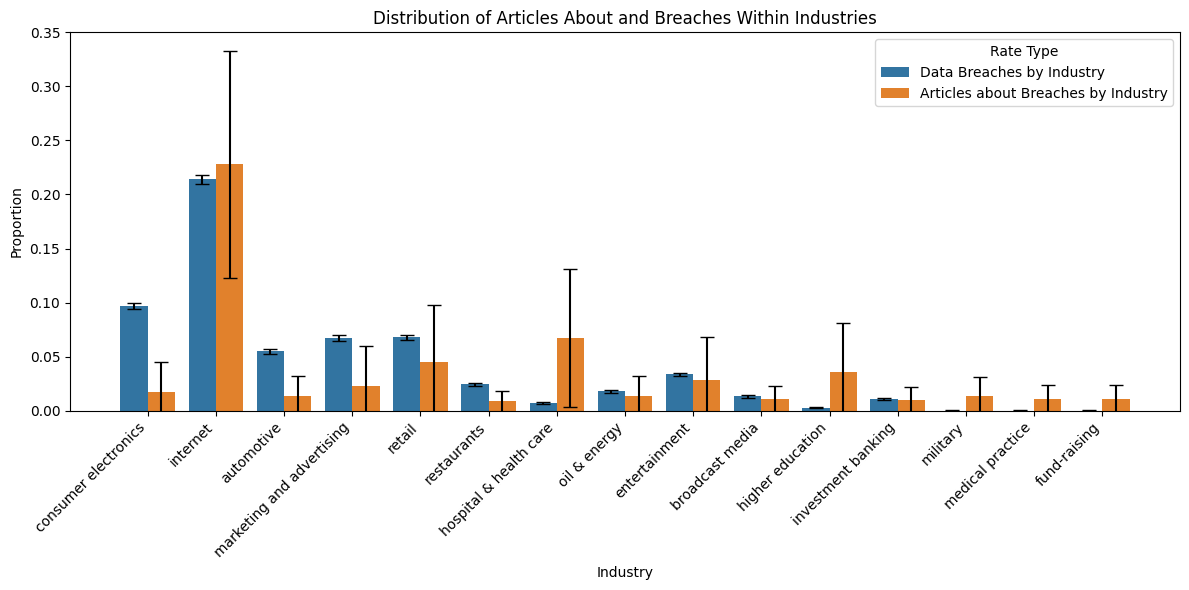

In [25]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=df_viz,
    x="industry",
    y="Rate",
    hue="Rate Type",
    #palette="muted",
    errorbar=None
)

# Add error bars manually
for i, bar in enumerate(list(barplot.patches)[:-2]):
    # Calculate position
    group_index = i // 2  # Each group (Industry) has 2 bars
    error = df_viz["Error"].iloc[i]
    plt.errorbar(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height(),  # Top of the bar
        yerr=error,  # Error value
        fmt="none",  # No marker
        c="black",  # Color of error bars
        capsize=5  # Cap size
    )
barplot.set_ylim(0, 0.35)
plt.title("Distribution of Articles About and Breaches Within Industries")
plt.xlabel("Industry")
plt.ylabel("Proportion")
plt.legend(title="Rate Type", labels=["Data Breaches by Industry", "Articles about Breaches by Industry"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()